# Descrição do Problema

O presente trabalho visa desenvolver um sistema de inteligência artificial para a detecção e classificação de gases, um problema de grande relevância para a segurança industrial, monitoramento da qualidade do ar e automação residencial. A capacidade de identificar a presença e o tipo de gás em um ambiente é crucial para prevenir acidentes, como intoxicações ou explosões, e para acionar sistemas de alerta ou ventilação.

O objetivo específico desta etapa é construir e treinar um modelo de rede neural convolucional (CNN) capaz de classificar um ambiente em uma de quatro categorias (sem gás, perfume, fumaça ou uma mistura dos dois) apenas com base em sua imagem térmica. A hipótese é que as diferentes condições geram assinaturas térmicas distintas – seja pela dispersão de partículas ou por variações de temperatura – que podem ser capturadas e aprendidas por um modelo de visão computacional.

Para resolver este problema de classificação de imagens, foi utilizada a técnica de Aprendizagem por Transferência (Transfer Learning). Selecionamos o modelo MobileNetV3 Small, pré-treinado na base de dados ImageNet. A estratégia consiste em congelar os pesos das camadas convolucionais (que são excelentes extratores de características visuais) e treinar apenas uma nova camada de classificação, adaptada para as classes específicas do nosso problema.

# Conjunto de Dados Utilizado

Para este estudo, utilizamos o dataset público "MultimodalGasData: Multimodal Dataset for Gas Detection and Classification".

Citação:
> Narkhede, Parag; Walambe, Rahee ; Chandel, Pulkit; Mandaokar, Shruti; Kotecha, Ketan (2022), “MultimodalGasData: Multimodal Dataset for Gas Detection and Classification”, Mendeley Data, V2, doi: 10.17632/zkwgkjkjn9.2

Este conjunto de dados é inerentemente multimodal, contendo medições simultâneas de sete sensores de gás de óxido de metal (MQ2, MQ3, MQ5, MQ6, MQ7, MQ8, MQ135) e imagens de uma câmera térmica. No entanto, para os fins desta primeira entrega, utilizamos exclusivamente o subconjunto de imagens térmicas.

- Estrutura e Classes: O dataset está dividido em quatro classes distintas, que representam os cenários a serem classificados:
  - No Gas (Ausência de gás)
  - Perfume (Presença de perfume)
  - Smoke (Presença de fumaça)
  - Mixture (Mistura de perfume e fumaça)

  O código carrega as imagens de seus respectivos diretórios, usando os nomes dos diretórios como rótulos para o treinamento.

- Pré-processamento: Antes de serem enviadas para a rede neural, as imagens passam por uma série de transformações:
  - Redimensionamento: Todas as imagens são redimensionadas para 224x224 pixels, o que padroniza a entrada para o modelo MobileNetV3.
  - Conversão para Tensor: As imagens são convertidas para o formato de tensores do PyTorch.
  - Normalização: Os valores dos pixels são normalizados para terem uma média de 0.5 e um desvio padrão de 0.5. Este passo é fundamental para garantir um treinamento estável e eficiente.

- Divisão dos Dados: Para treinar e avaliar o modelo de forma robusta, o conjunto de dados foi dividido em três subconjuntos:
  - Treinamento (70%): Utilizado para o ajuste dos pesos da camada de classificação do modelo.
  - Validação (15%): Usado durante o treinamento para monitorar o desempenho, evitar overfitting e salvar o melhor modelo.
  - Teste (15%): Reservado para a avaliação final do modelo, fornecendo uma métrica imparcial de sua capacidade de generalização em dados nunca vistos.

# Prática 1

In [ ]:
import imageio.v3 as iio
import os
import numpy as np
import matplotlib.pyplot as plt

## Carregando as imagens

In [ ]:
import pandas as pd
from PIL import Image
image_paths = "./dados/Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images"
df_images = pd.DataFrame()
for label in os.listdir(image_paths):
    for image in os.listdir(f"{image_paths}/{label}"):
        if not image.endswith(".png"):
            continue

        new_row = pd.DataFrame([{
            "path": image,
            "label": label
        }])

        df_images = pd.concat([df_images, new_row]).reset_index(drop=True)

df_images.to_csv("images.csv", index=False)


In [ ]:
df_images["path"].count()

np.int64(6400)

Text(0.5, 1.0, 'Distribuição das labels na base de dados.')

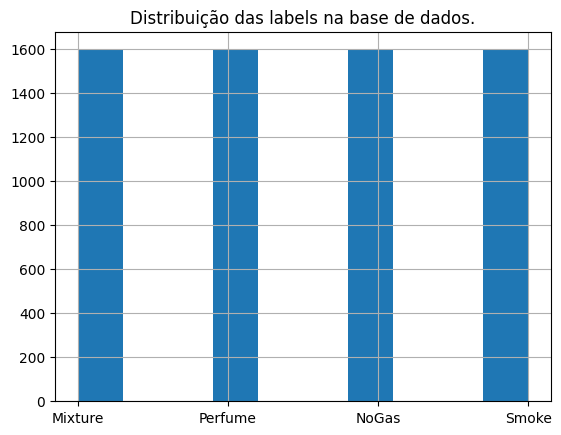

In [ ]:
df_images["label"].hist()
plt.title("Distribuição das labels na base de dados.")

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torch.utils.data import Dataset

## Criando o dataset

In [ ]:
image_paths = "./dados/Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images"
class SmokeDetectorImageDataset(Dataset):
    def __init__(self, img_dirs, annotations_file, transform=None, target_transform=None):
        self.imgs = pd.read_csv(annotations_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.target_transform = target_transform
        self.labels = sorted(os.listdir(self.img_dirs))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs.iloc[idx, 0]
        label = self.labels.index(self.imgs.iloc[idx, 1])
        image = decode_image(os.path.join(f"{self.img_dirs}/{self.labels[label]}",img_path), mode="RGB")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
full_images = SmokeDetectorImageDataset(image_paths, "images.csv", transform)

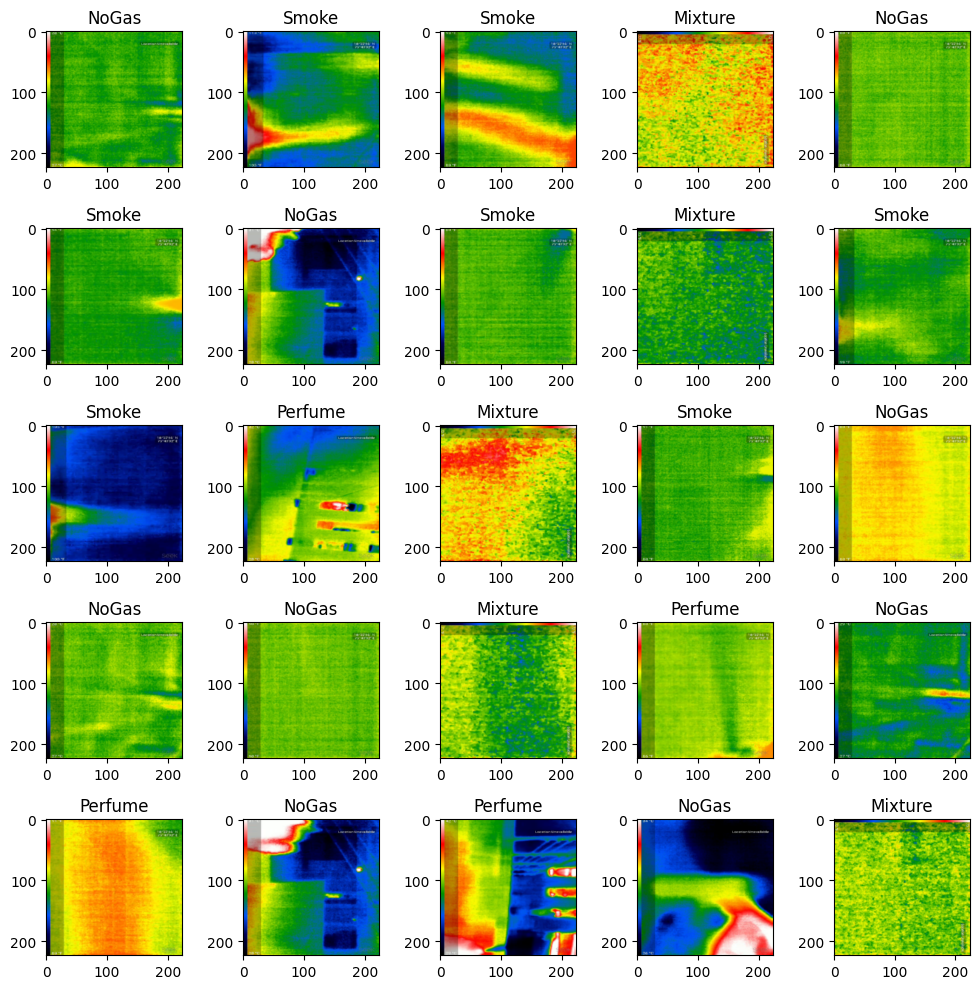

In [ ]:
from random import randint
n = 5

fig, ax = plt.subplots(n, n, figsize=(10, 10))

for i in range(n*n):
  i_random = randint(0, len(full_images))
  img = full_images[i_random][0] / 2 + 0.5
  npimg = img.numpy()
  ax[i // n, i % n].imshow(np.transpose(npimg, (1, 2, 0)))
  ax[i // n, i % n].set_title(full_images.labels[full_images[i_random][1]])

fig.tight_layout()
plt.show()

In [ ]:
# Carregando o dispositivo
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Criando o modelo

Estamos utilizando o modelo [MobileNet V3 Small](https://arxiv.org/abs/1905.02244). Alteraremos a ultima camada para classificar entre as 5 categorias da nossa base.

In [ ]:
import torchvision.models as models

# Carregando modelo
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT).to(device)

# Desligando o Gradient para todas as camadas.
for param in model.parameters():
    param.requires_grad = False

# Modificar a última camada para classificar em 5 classes.
in_features = model.classifier[-1].in_features
num_classes = 4
new_classifier = torch.nn.Linear(in_features, num_classes)

model.classifier[-1] = new_classifier

In [ ]:
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_images, [0.70, 0.15, 0.15])

In [ ]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    "val": DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2),
    "test": DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2),
}

In [ ]:
import time
from tempfile import TemporaryDirectory

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

def train_model(model, criterion, device, optimizer, num_epochs=25):
    since = time.time()

    best_acc = 0.0
    accuracys = {
        "train": [],
        "val": []
    }

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Mudar estado do modelo para treinamento
                else:
                    model.eval()   # Mudar estado do modelo para validação

                running_loss = 0.0
                running_corrects = 0
                loss = None
                preds = []

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                accuracys[phase].append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, accuracys


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model, accuracys = train_model(model, criterion, device, optimizer_ft, num_epochs=50)

Epoch 1/50
----------


train Loss: 0.4806 Acc: 0.8420
val Loss: 0.4355 Acc: 0.8573

Epoch 2/50
----------
train Loss: 0.2685 Acc: 0.9103
val Loss: 0.2838 Acc: 0.9115

Epoch 3/50
----------
train Loss: 0.2259 Acc: 0.9192
val Loss: 0.2148 Acc: 0.9271

Epoch 4/50
----------
train Loss: 0.2031 Acc: 0.9315
val Loss: 0.1834 Acc: 0.9354

Epoch 5/50
----------
train Loss: 0.1904 Acc: 0.9326
val Loss: 0.1729 Acc: 0.9437

Epoch 6/50
----------
train Loss: 0.1766 Acc: 0.9404
val Loss: 0.1619 Acc: 0.9500

Epoch 7/50
----------
train Loss: 0.1593 Acc: 0.9435
val Loss: 0.1589 Acc: 0.9490

Epoch 8/50
----------
train Loss: 0.1639 Acc: 0.9319
val Loss: 0.1520 Acc: 0.9542

Epoch 9/50
----------
train Loss: 0.1652 Acc: 0.9426
val Loss: 0.1527 Acc: 0.9490

Epoch 10/50
----------
train Loss: 0.1505 Acc: 0.9442
val Loss: 0.1429 Acc: 0.9573

Epoch 11/50
----------
train Loss: 0.1467 Acc: 0.9487
val Loss: 0.1448 Acc: 0.9490

Epoch 12/50
----------
train Loss: 0.1404 Acc: 0.9475
val Loss: 0.1404 Acc: 0.9469

Epoch 13/50
----------


Melhor acurácia: 96%

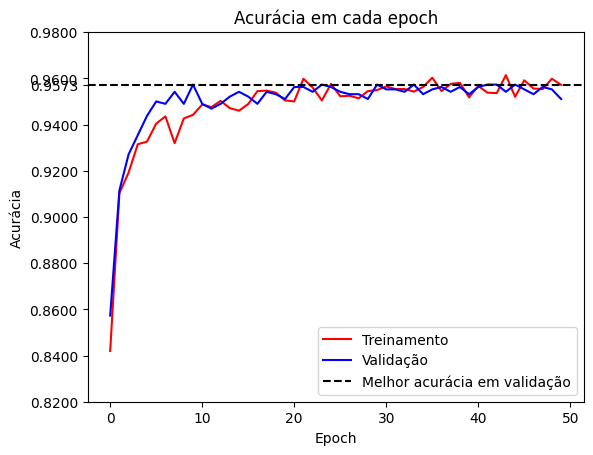

In [ ]:
best = max(accuracys["val"])

plt.title("Acurácia em cada epoch")
plt.plot(accuracys["train"], c='r', label="Treinamento")
plt.plot(accuracys["val"], c='b', label="Validação")
plt.axhline(y=best, label='Melhor acurácia em validação', ls='--', c="black")

yticks = list(plt.yticks())[0].tolist() + [best]
plt.yticks(yticks)

plt.xlabel("Epoch")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

## Testando

In [ ]:
dataiter = iter(dataloaders["test"])
images, labels = next(dataiter)
# print images
print(f'GroundTruth: {[full_images.labels[labels[j]] for j in range(len(labels))]}')

GroundTruth: ['Smoke', 'Mixture', 'Mixture', 'NoGas', 'Mixture', 'Mixture', 'NoGas', 'Mixture', 'Smoke', 'Smoke', 'Smoke', 'Mixture', 'Smoke', 'Perfume', 'Mixture', 'Mixture', 'Smoke', 'Perfume', 'NoGas', 'Perfume', 'Mixture', 'NoGas', 'NoGas', 'NoGas', 'Perfume', 'Mixture', 'NoGas', 'Perfume', 'Perfume', 'Mixture', 'Smoke', 'Perfume']


In [ ]:
outputs = model(images)
_, preds = torch.max(outputs, 1)
print(f'Predicted: {[full_images.labels[preds[j]] for j in range(len(labels))]}')
print(f"Accuracy: {torch.sum(labels.data == preds)/len(labels)}")

Predicted: ['Smoke', 'Mixture', 'Mixture', 'NoGas', 'Mixture', 'Mixture', 'NoGas', 'Mixture', 'Smoke', 'Smoke', 'Smoke', 'Mixture', 'Smoke', 'Perfume', 'Mixture', 'Mixture', 'Smoke', 'Perfume', 'NoGas', 'Perfume', 'Mixture', 'NoGas', 'NoGas', 'NoGas', 'Perfume', 'Mixture', 'NoGas', 'NoGas', 'Perfume', 'Mixture', 'Smoke', 'Perfume']
Accuracy: 0.96875


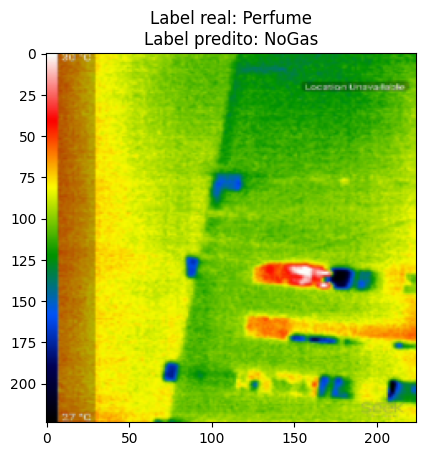

In [ ]:
for i in range(len(labels)):
    if labels[i] != preds[i]:
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Label real: {full_images.labels[labels[i]]}\nLabel predito: {full_images.labels[preds[i]]}")
        plt.show()